**Загрузка и подготовка данных**

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

DS_PATH = '/content/drive/MyDrive/Datasets for ORG-4(SentimentAnalysisWithObjectDetection)/'

Mounted at /content/drive


In [ ]:
import random
DF = pd.read_csv(DS_PATH + 'women_with_predict.csv',encoding='utf-8',lineterminator='\n')

data = DF[['text','label']]
data = data.dropna()

data_l0 = data.loc[DF['label'] == 0]
data_l1 = data.loc[DF['label'] == 1]
data_l2 = data.loc[DF['label'] == 2]
data_l = [[data_l0, 0], [data_l1, 0], [data_l2, 0]]
data = pd.DataFrame(columns=['text', 'label'] )

min_count_of_entries_in_labels = min(len(data_l0), len(data_l1), len(data_l2))
for i in range(min_count_of_entries_in_labels * 3):
  j = random.randint(0,2)
  data = data.append(data_l[j][0].iloc[data_l[j][1]])
  if data_l[j][1] < min_count_of_entries_in_labels - 1:
    data_l[j][1] += 1

tmp = round(len(data)* 0.6)
tmp_1 = round(len(data) * 0.8)

train_data = data.iloc[0:tmp]
val_data = data.iloc[tmp:tmp_1]
test_data = data.iloc[tmp_1:len(data)]

train_text = train_data['text'].astype('str')
train_labels = train_data['label'].astype('int')
val_text = val_data['text'].astype('str')
val_labels = val_data['label'].astype('int')
test_text = test_data['text'].astype('str')
test_labels = test_data['label'].astype('int')

**Подключение библиотек**

In [ ]:
!pip install transformers
import torch
from transformers import BertTokenizer

**Загрузка токенизатора с модели DeepPavlov/rubert-base-cased**

In [ ]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

Downloading:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

**График длин отзывов**

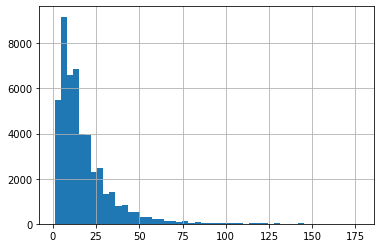

In [ ]:
seq_len = [len(str(i).split()) for i in train_text]
pd.Series(seq_len).hist(bins = 50)

**Токенизация данных**

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tokens_train = tokenizer.batch_encode_plus(
    train_text.values,
    max_length = 65,
    padding = 'max_length',
    truncation = True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.values,
    max_length = 65,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.values,
    max_length = 65,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.values)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.values)
batch_size = 32


train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data =  TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

test_data = TensorDataset(test_seq, test_mask)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

**Загружаем модель DeepPavlov/rubert-base-cased, добавляем 3 выхода**

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", 
                                                      num_labels = 3, 
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

n_epochs = 3

n_steps = len(train_dataloader) * n_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = n_steps)

**Дообучение модели**

In [ ]:
from datetime import timedelta
import time
from sklearn.metrics import classification_report
import numpy as np

device = torch.device("cuda")
seed = 42
random.seed = (seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
model.cuda()

losses = []

for epoch in range(n_epochs):
    print("Training:")
    start = time.time()
    mean_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        
        torch.cuda.empty_cache()
        if (step + 1) % 100 == 0:
            duration = timedelta(seconds=int(time.time() - start))
            print('Batch {:>5,}  of  {:>5,}.    Time: {:}.'.format(step + 1, len(train_dataloader), duration))
        b_input_ids = batch[0].to(device)
        b_attention_masks = batch[1].to(device)
        b_targets = batch[2].to(device)
        model.zero_grad()
        
        torch.cuda.empty_cache()
        outputs = model(b_input_ids, attention_mask=b_attention_masks, labels = b_targets)
        loss = outputs[0]
        
        mean_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        mean_loss = mean_loss / len(train_dataloader)
    
    losses.append(mean_loss)
    print("Mean loss: " , mean_loss)
    print("Training epoch took:" , timedelta(seconds=int(time.time() - start)))
    
    print()
    print("Validation:")
    model.eval()
    
    start = time.time()
    predictions = torch.Tensor().to(dtype=torch.int8)
    
    for batch in val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_attention_masks = batch[1].to(device)
        b_targets = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attention_masks, output_hidden_states=False, output_attentions=False, return_dict=True)
        
        predictions = torch.cat((predictions, outputs.logits.cpu().argmax(axis=1)))
        torch.cuda.empty_cache()
        
    print(classification_report(val_y, predictions))
    print("Validation took: {:}".format(timedelta(seconds = int(time.time() - start))))
    print()

Training:
Batch   100  of  1,510.    Time: 0:00:41.
Batch   200  of  1,510.    Time: 0:01:21.
Batch   300  of  1,510.    Time: 0:02:02.
Batch   400  of  1,510.    Time: 0:02:43.
Batch   500  of  1,510.    Time: 0:03:25.
Batch   600  of  1,510.    Time: 0:04:07.
Batch   700  of  1,510.    Time: 0:04:50.
Batch   800  of  1,510.    Time: 0:05:32.
Batch   900  of  1,510.    Time: 0:06:15.
Batch 1,000  of  1,510.    Time: 0:06:57.
Batch 1,100  of  1,510.    Time: 0:07:40.
Batch 1,200  of  1,510.    Time: 0:08:23.
Batch 1,300  of  1,510.    Time: 0:09:05.
Batch 1,400  of  1,510.    Time: 0:09:48.
Batch 1,500  of  1,510.    Time: 0:10:30.
Mean loss:  0.000452986409118897
Training epoch took: 0:10:35

Validation:
              precision    recall  f1-score   support

           0       0.64      0.76      0.69      5466
           1       0.92      0.85      0.88      5339
           2       0.78      0.69      0.73      5295

    accuracy                           0.77     16100
   macro avg 

**Тестирование модели**

In [ ]:
print("Testing:")
model.eval()

t0 = time.time()
predictions = torch.Tensor().to(dtype=torch.int8)

for batch in test_dataloader:

    b_input_ids = batch[0].to(device)
    b_attention_masks = batch[1].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_attention_masks, output_hidden_states=False, output_attentions=False, return_dict=True)

    predictions = torch.cat((predictions, outputs.logits.cpu().argmax(axis=1)))

print(classification_report(test_y ,predictions))

Testing:
              precision    recall  f1-score   support

           0       0.66      0.69      0.67      5338
           1       0.92      0.86      0.89      5375
           2       0.75      0.75      0.75      5387

    accuracy                           0.77     16100
   macro avg       0.77      0.77      0.77     16100
weighted avg       0.77      0.77      0.77     16100

